# **Import Packages**

In [ ]:
import json
import nltk
nltk.download('vader_lexicon')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# **Sentiment classification (bar chart)**

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


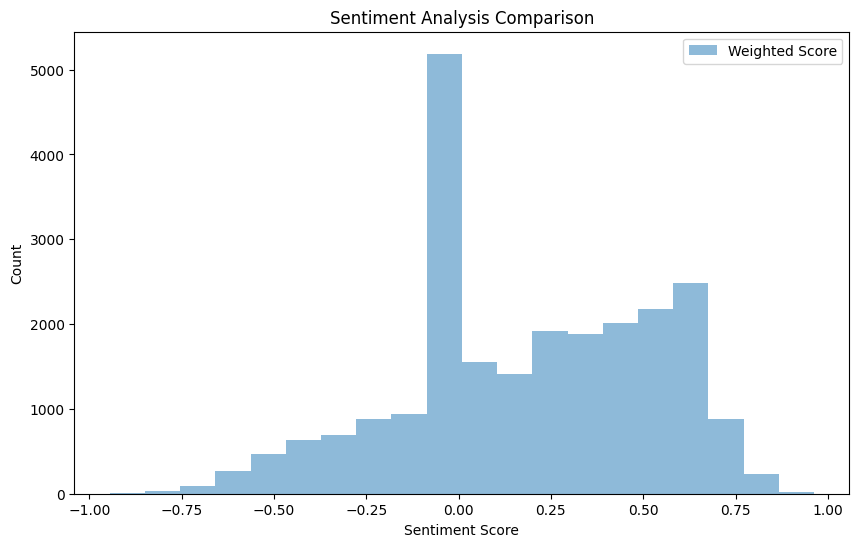

In [ ]:
# Load the preprocessed file
with open('Processed_GPT_total.json', 'r') as file:
    data = json.load(file)

# Extract text data
texts = []
for item in data:
    texts.append(item['body'])  # Choose the necessary field based on actual context

# Use TextBlob for sentiment classification
textblob_scores = []
for text in texts:
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    textblob_scores.append(sentiment)

# Use VADER for sentiment classification
vader_scores = []
analyzer = SentimentIntensityAnalyzer()
for text in texts:
    scores = analyzer.polarity_scores(text)
    vader_scores.append(scores['compound'])

# Weighted processing
textblob_weight = 0.4
vader_weight = 0.6

weighted_scores = [(textblob_weight * tb + vader_weight * vd) for tb, vd in zip(textblob_scores, vader_scores)]

# Build DataFrame
df = pd.DataFrame({'TextBlob': textblob_scores, 'VADER': vader_scores, 'Weighted Score': weighted_scores})

# Plot visualization results
plt.figure(figsize=(10, 6))
plt.hist(df['Weighted Score'], bins=20, alpha=0.5, label='Weighted Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Analysis Comparison')
plt.legend()
plt.show()

# **Sentiment classification (pie chart)**

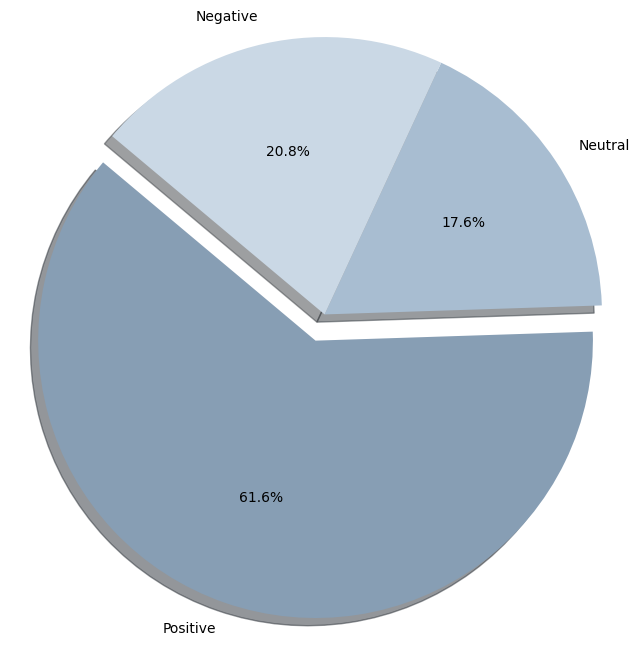

In [ ]:
# Calculate sentiment classification proportions
positive_count = len([score for score in weighted_scores if score > 0])
neutral_count = len([score for score in weighted_scores if score == 0])
negative_count = len([score for score in weighted_scores if score < 0])

# Pie chart data
labels = ['Positive', 'Neutral', 'Negative']
sizes = [positive_count, neutral_count, negative_count]
colors = ['#879eb4', '#a8bdd1', '#cad8e5']  # Light blue-gray
explode = (0.1, 0, 0)  # Separate the "Positive" section

# Draw the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Ensure it remains a circle
plt.show()

# **Emoji word clouds for different emotions**

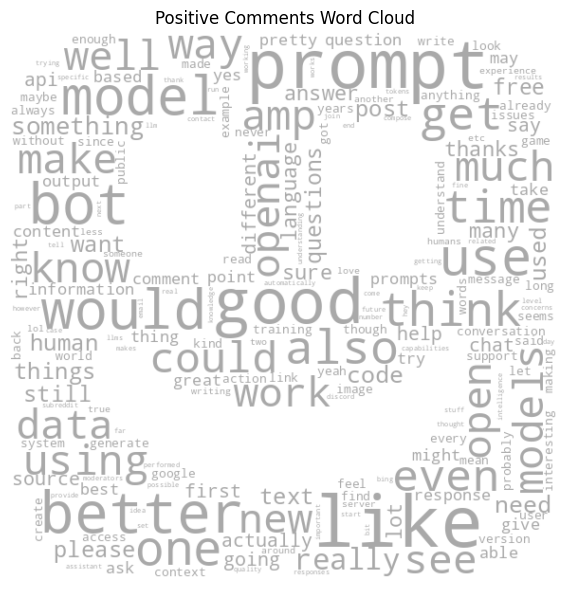

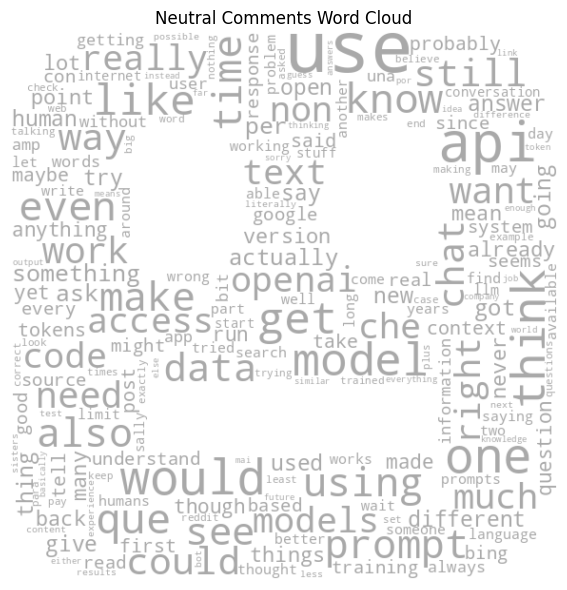

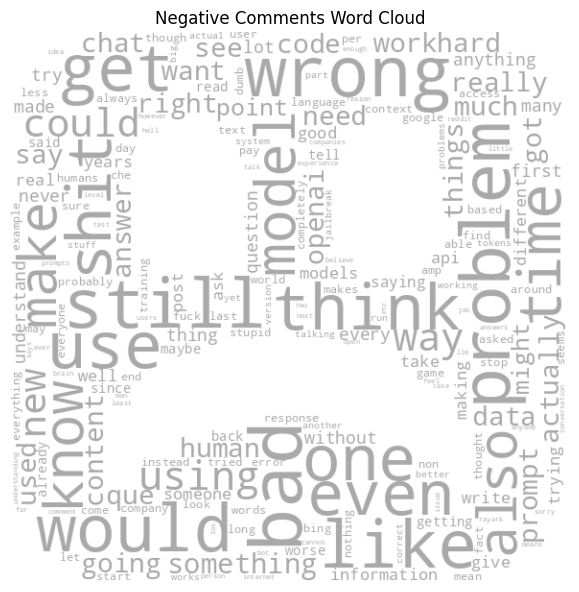

In [ ]:
# List of words to ignore
ignore_words = []

# Filter out words that you don't want to display
positive_words = [word for word in positive_words if word not in ignore_words]
neutral_words = [word for word in neutral_words if word not in ignore_words]
negative_words = [word for word in negative_words if word not in ignore_words]

# Load shape images
shape_positive = np.array(Image.open("positive.png"))
shape_neutral = np.array(Image.open("neutral.png"))
shape_negative = np.array(Image.open("negative.png"))

# Create a custom color function that returns dark gray
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(169, 169, 169)"  # RGB color code for dark gray

# Create a function for the word cloud
def create_wordcloud(words, shape, title, target_words=None):
    word_freq = Counter(words)

    if target_words:
        for target_word in target_words:
            if target_word in word_freq:
                word_freq[target_word] *= 2  # Increase the frequency of the target word

    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color='white',
        mask=shape,
        contour_color='gray',     # Set contour color
        max_font_size=75,

        stopwords=set(ignore_words),
        color_func=grey_color_func  # Set font color to dark gray
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(6, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, color='black')
    plt.tight_layout()
    plt.savefig(title.lower().replace(" ", "_") + ".png")  # Save the image
    plt.show()

# Create a word cloud for positive comments and increase the frequency of specific words
create_wordcloud(positive_words, shape_positive, 'Positive Comments Word Cloud')

# Create a word cloud for neutral comments and increase the frequency of specific words
create_wordcloud(neutral_words, shape_neutral, 'Neutral Comments Word Cloud')

# Create a word cloud for negative comments and increase the frequency of specific words
create_wordcloud(negative_words, shape_negative, 'Negative Comments Word Cloud')


# **Changes in Positive and Negative Emotions over Time**

In [ ]:
!pip install nltk

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


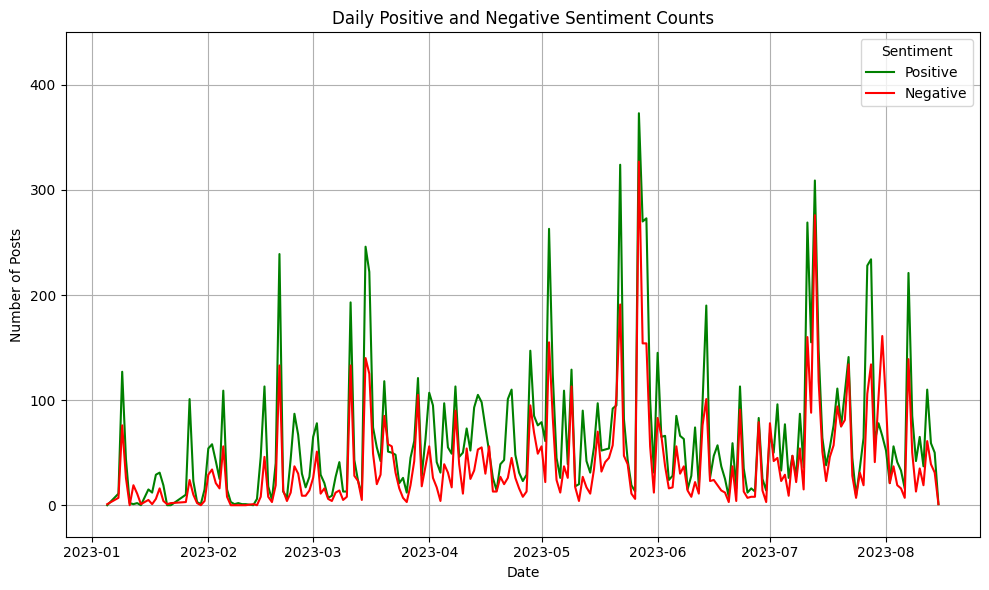

In [ ]:
# Load the preprocessed file
with open('Processed_GPT_total.json', 'r') as file:
    data = json.load(file)

# Extract date and text data
dates = []
texts = []
for item in data:
    if item['createdAt'][:4] >= '2023':  # Only keep posts from 2023 and later
        dates.append(item['createdAt'][:10])
        texts.append(item['body'])  # Choose the required field based on the actual situation

# Calculate sentiment scores using TextBlob and VADER
textblob_weight = 0.4
vader_weight = 0.6

textblob_scores = []
vader_scores = []
analyzer = SentimentIntensityAnalyzer()

for text in texts:
    blob = TextBlob(text)
    textblob_scores.append(blob.sentiment.polarity)

    scores = analyzer.polarity_scores(text)
    vader_scores.append(scores['compound'])

# Weight the results
weighted_scores = [(textblob_weight * tb + vader_weight * vd) for tb, vd in zip(textblob_scores, vader_scores)]

# Construct the data frame
df = pd.DataFrame({'Date': dates, 'Weighted Score': weighted_scores})

# Convert the Date column to a datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Calculate the number of positive and negative sentiments daily
df['Sentiment'] = df['Weighted Score'].apply(lambda score: 'Positive' if score > 0 else 'Negative')

# Group by date and sentiment, then calculate daily sentiment counts
daily_sentiment_counts = df.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)

# Plot the daily positive and negative sentiment counts over time
plt.figure(figsize=(10, 6))
plt.plot(daily_sentiment_counts.index, daily_sentiment_counts['Positive'], label='Positive', color='green')
plt.plot(daily_sentiment_counts.index, daily_sentiment_counts['Negative'], label='Negative', color='red')
plt.title('Daily Positive and Negative Sentiment Counts')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Sentiment')
plt.ylim(-30,450)
plt.grid()
plt.tight_layout()
plt.show()